In [1]:
import numpy as np
import torch

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
impath = '/mnt/fs0/datasets/ImageNet21k/'
emb_path = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects'

# Data

In [4]:
# Wordnet tools
import pandas as pd
wordnet_wnids_labels = pd.read_csv('../manifold_old/data/words.txt', sep='\t')
wordnet_wnids_labels = wordnet_wnids_labels.to_numpy()
wordnet_wnids = wordnet_wnids_labels[:,0]
wordnet_labels = wordnet_wnids_labels[:,1]

wnids_1k = np.load(os.path.join(emb_path,'wnids_1k.npy'))

In [5]:
def label_from_wnid(wnid):
    return wordnet_labels[np.where(wordnet_wnids==wnid)[0]][0]

In [6]:
# Image preprocessing
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
from PIL import Image

def get_batch(i, wnid_dir, imgs, batch_size):
    xbatch = []
    for img in imgs[i*batch_size:(i+1)*batch_size]:
        try:
            x = Image.open(os.path.join(wnid_dir, img)).convert('RGB')
            xbatch.append(preprocess(x))
        except OSError: 
            pass

    return torch.stack(xbatch)

In [8]:
from torchvision.utils import make_grid
def show_grid(im_tensor, nrow=8, title=None):
    im_grid = make_grid(im_tensor, nrow=nrow, padding=2)
    im_grid = im_grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    im_grid = std * im_grid + mean
    im_grid = np.clip(im_grid, 0, 1)
    
    plt.figure(figsize=(15,2*len(input_tensor)//nrow))
    plt.imshow(im_grid)
    plt.axis('off')
    plt.title(title)

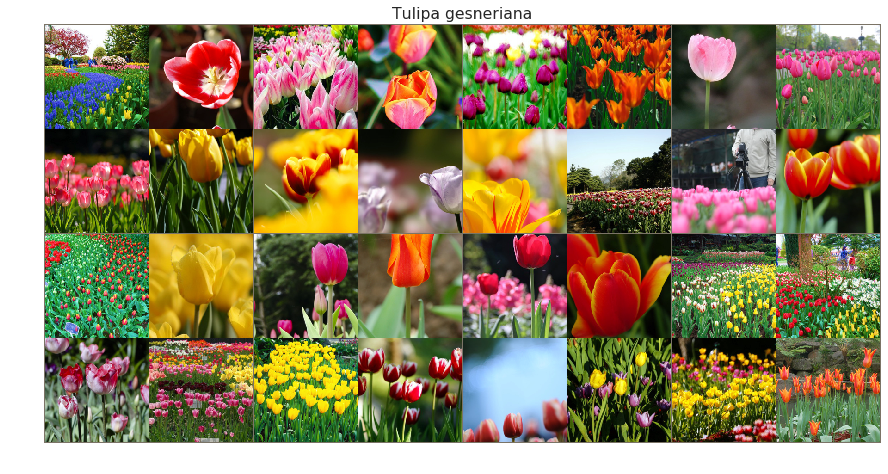

In [9]:
batch_size = 32
wnid = wnids_1k[12]
wnid_dir = os.path.join(impath, wnid)
imgs = os.listdir(wnid_dir)

input_tensor = get_batch(0, wnid_dir, imgs, batch_size)

show_grid(input_tensor, title=label_from_wnid(wnid))

# Model

In [54]:
model_name = 'resnet50'
repo = 'pytorch/vision:v0.6.0'
# repo = 'rwightman/gen-efficientnet-pytorch'
model = torch.hub.load(repo, model_name, pretrained=True)

model_dir = os.path.join(emb_path,model_name)

Using cache found in /home/bsorsch/.cache/torch/hub/pytorch_vision_v0.6.0


In [55]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
class AlexnetBackbone(torch.nn.Module):
    def __init__(self, model):
        super(AlexnetBackbone, self).__init__()
        self.N = list(model.children())[-1][-1].weight.shape[-1]
        self.pre_features = torch.nn.Sequential(*list(model.children())[:-1])
        self.features = torch.nn.Sequential(*list(model.children())[-1][:-1])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.pre_features(x)
        x = self.flatten(x)
        x = self.features(x)
        return x


class SqueezeBackbone(torch.nn.Module):
    def __init__(self, model):
        super(SqueezeBackbone, self).__init__()
        self.N = list(model.children())[-1][-3].weight.shape[-1]
        self.pre_features = torch.nn.Sequential(*list(model.children())[:-1])
        self.features = torch.nn.Sequential(*list(model.children())[-1][:-1])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.pre_features(x)
        x = self.features(x)
        x = self.flatten(x)
        return x


class WideResNetBackbone(torch.nn.Module):
    def __init__(self, model, module_idx):
        super(WideResNetBackbone, self).__init__()
        self.N = list(model.children())[-1].weight.shape[-1]
        self.features = torch.nn.Sequential(*list(model.children())[:-module_idx])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        return x

    
class VGGBackbone(torch.nn.Module):
    def __init__(self, model):
        super(VGGBackbone, self).__init__()
        self.N = list(model.children())[-1][3].weight.shape[-1]
        self.pre_features = torch.nn.Sequential(*list(model.children())[:-1])
        self.features = torch.nn.Sequential(*list(model.children())[-1][:-1])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.pre_features(x)
        x = self.flatten(x)
        x = self.features(x)
        x = self.flatten(x)
        return x
    
    
class EfficientNetBackbone(torch.nn.Module):
    def __init__(self, model):
        super(EfficientNetBackbone, self).__init__()
        self.N = list(model.children())[-1].weight.shape[-1]
        self.pre_features = torch.nn.Sequential(*list(model.children())[:-1])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.pre_features(x)
        x = self.flatten(x)
        return x

In [13]:
random_projection=True
if 'resnet' in model_name or 'resnext' in model_name:
    backbone = WideResNetBackbone(model, 1)
    random_projection=False
elif 'vgg' in model_name:
    backbone = VGGBackbone(model)
elif 'alexnet' in model_name:
    backbone = AlexnetBackbone(model)
elif 'squeeze' in model_name:
    backbone = SqueezeBackbone(model)
elif 'efficient' in model_name:
    backbone = model
    backbone.N = 1000
    random_projection=False
#     backbone = EfficientNetBackbone(model)
backbone.to('cuda').eval()

WideResNetBackbone(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

# Representations

In [14]:
N = 2048
P = 500
batch_size = 16

if random_projection:
    input_tensor = get_batch(0, wnid_dir, imgs, batch_size)
    U = torch.randn(backbone.N, N) / np.sqrt(N)
    U = U.cuda()

print('Getting embeddings. Saving to: ' + model_dir)
manifolds = []
for wnid in tqdm(wnids_1k):
    wnid_dir = os.path.join(impath, wnid)
    imgs = os.listdir(wnid_dir)
    
    manifold = []
    for i in range(len(imgs)//batch_size):
        input_tensor = get_batch(i, wnid_dir, imgs, batch_size)
        with torch.no_grad():
            output = backbone(input_tensor.cuda())
        if random_projection:
            manifold.append((output@U).cpu().numpy())
        else:
            manifold.append(output.cpu().numpy())
    manifold = np.concatenate(manifold)
    manifolds.append(manifold)
    
# Keep only P examples for each manifold
counts = [len(m) for m in manifolds]
# P = np.min(counts)
# manifolds = [m[:P] for m in manifolds]
# manifolds = np.stack(manifolds)
    
# # # Save dir
# if  not os.path.isdir(model_dir):
#     os.mkdir(model_dir)
# np.save(model_dir + 'manifolds.npy', manifolds)
# np.save(model_dir + 'labels.npy', labels)

Getting embeddings. Saving to: /mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/wide_resnet50_2


/home/bsorsch/.tf2/lib/python3.5/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/bsorsch/.tf2/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/home/bsorsch/.tf2/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/home/bsorsch/.tf2/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 264 bytes but only got 252. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.tf2/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/home/bs

In [15]:
for i in tqdm(range(len(manifolds))):
    norms = np.linalg.norm(manifolds[i],axis=-1)
    _,uniq_idxs = np.unique(norms,return_index=True)
    manifolds[i] = manifolds[i][uniq_idxs]

In [16]:
counts = [len(m) for m in manifolds]
np.min(counts)

729

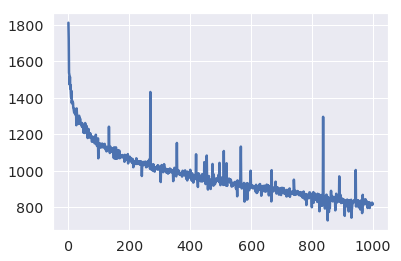

In [17]:
plt.plot(counts)

In [18]:
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Save manifolds
np.save(os.path.join(model_dir,'manifolds.npy'),manifolds[:1000])

# Geometry

In [15]:
manifolds_load = np.load(os.path.join(model_dir,'manifolds.npy'),allow_pickle=True)

In [17]:
P = 500
manifolds = []
for manifold in manifolds_load:
    manifolds.append(manifold[:P])
manifolds = np.stack(manifolds)

In [18]:
Rs = []
centers = []
Us = []
for manifold in tqdm(manifolds):
    center = manifold.mean(0)
    centers.append(center)
    _,R,U = np.linalg.svd(manifold - center)
    Rs.append(R[:P])
    Us.append(U[:P])
Rs = np.stack(Rs)
centers = np.stack(centers)
Us = np.stack(Us)

In [19]:
# Save geometry
np.save(os.path.join(model_dir,'Rs.npy'),Rs)
np.save(os.path.join(model_dir,'Us.npy'),Us)
np.save(os.path.join(model_dir,'centers.npy'),centers)

In [22]:
n_plots = 1000
K = len(centers)
ss = []
csa = []
csb = []
for a in tqdm(range(n_plots)):
    for b in range(K):
        if a!=b:
            # Center-subspace
            dx0 = centers[a] - centers[b]
            dx0hat = dx0 / np.linalg.norm(dx0)
            costheta_a = Us[a]@dx0hat
            csa.append((costheta_a**2 * Rs[a]**2).sum() / (Rs[a]**2).sum())
            costheta_b = Us[b]@dx0hat
            csb.append((costheta_b**2 * Rs[b]**2).sum() / (Rs[a]**2).sum())
            
            # Subspace-subspace
            cosphi = Us[a]@Us[b].T
            ss_overlap = (cosphi**2*Rs[a][:,None]**2*Rs[b]**2).sum() / (Rs[a]**2).sum()**2
            ss.append(ss_overlap)
        else:
            csa.append(np.nan)
            csb.append(np.nan)
            ss.append(np.nan)
csa = np.stack(csa).reshape(n_plots,K)
csb = np.stack(csb).reshape(n_plots,K)
ss = np.stack(ss).reshape(n_plots,K)

In [23]:
np.save(os.path.join(model_dir,'center_subspace_a.npy'),csa)
np.save(os.path.join(model_dir,'center_subspace_b.npy'),csb)
np.save(os.path.join(model_dir,'subspace_subspace.npy'),ss)

# Generalization error

In [4]:
model_name = 'resnet50'
model_dir = os.path.join(emb_path,model_name)

In [5]:
manifolds_load = np.load(os.path.join(model_dir, 'manifolds.npy'),allow_pickle=True)

In [6]:
# P = 500
# manifolds = []
# for manifold in manifolds_load:
#     manifolds.append(manifold[:P])
# manifolds = np.stack(manifolds)

In [25]:
from jax import numpy as np
from jax import jit
from numpy import random

In [26]:
manifolds = np.stack(manifolds)

In [36]:
n_classes = 1000
m = 1
n_test = 1000

@jit
def compute_2way_err():
    err_means = []
    err_stds = []
    for i in tqdm(range(n_classes), leave=False):
        err_mean = []
        err_std = []
        for j in range(n_classes):
            if i != j:
                X1 = manifolds[i]
                X2 = manifolds[j]

                idxs1 = random.randint(0, len(X1), [m, n_test])
                idxs2 = random.randint(0, len(X2), [m, n_test])
                mu1 = X1[idxs1].mean(0)
                mu2 = X2[idxs2].mean(0)
                w = mu1 - mu2
                mu = 0.5*(mu1 + mu2)
                pred = w.dot(X1.T) - (w*mu).sum(-1, keepdims=True)

                err = (pred <= 0).mean(-1)
                err_mean.append(err.mean())
                err_std.append(err.std())
        err_mean = np.stack(err_mean)
        err_std = np.stack(err_std)
        err_means.append(err_mean)
        err_stds.append(err_std)

    err_means = np.stack(err_means)
    err_stds = np.stack(err_stds)
    return err_means, err_stds

In [37]:
# Compute errors
err_mean, err_std = compute_2way_err()

# Save errs
# np.save(model_dir+'err_mean_1shot.npy', err_mean)
# np.save(model_dir+'err_std_1shot.npy', err_std)

In [29]:
1-np.mean(err_mean)

DeviceArray(0.98711455, dtype=float32)

In [38]:
1-np.mean(err_mean)

DeviceArray(0.9292901, dtype=float32)

In [39]:
np.save(os.path.join(model_dir,'errs_{}shot.npy'.format(m)),err_mean)

In [44]:
# Read synset files
import pandas as pd
wnids_21k = pd.read_csv('../manifold_old/data/imagenet_synset_list.txt').to_numpy().squeeze()

In [45]:
# Wordnet tools
import pandas as pd
wordnet = np.load('../manifold_old/data/wordnet_hierarchy.npy', allow_pickle=True)
synset_wnids = pd.read_csv('../manifold_old/data/words.txt', sep='\t')
synset_wnids = synset_wnids.to_numpy()

def class_from_wnid(wnid):
    return  synset_wnids[np.where(synset_wnids==wnid)[0], 1][0]

In [47]:
# Read synset files
synset_list = pd.read_csv('../manifold_old/data/imagenet_synset_list.txt')
synset_list = synset_list.to_numpy().squeeze()

# from utils import class_from_wnid
labels_21k = np.array([class_from_wnid(wnid) for wnid in synset_list])

# Theory

In [4]:
model_name = 'wide_resnet50_2'
model_dir = os.path.join(emb_path,model_name)

In [31]:
# errs_1shot = np.load(os.path.join(model_dir, 'errs_1shot.npy'))
errs_5shot = np.load(os.path.join(model_dir, 'errs_5shot.npy'))

In [8]:
centers = np.load(os.path.join(model_dir,'centers.npy'))
Rs = np.load(os.path.join(model_dir,'Rs.npy'))
# Us = np.load(os.path.join(model_dir,'Us.npy'))

In [32]:
from scipy.spatial.distance import pdist, squareform
dists = squareform(pdist(centers))
dist_norm = dists / np.sqrt((Rs**2).mean(-1)[:,None])

Dsvds = np.sum(Rs**2,axis=-1)**2 / np.sum(Rs**4, axis=-1)
print('Mean Dsvd: ' + str(np.mean(Dsvds)))

Mean Dsvd: 36.286297


In [6]:
csa = np.load(os.path.join(model_dir,'center_subspace_a.npy'))
csb = np.load(os.path.join(model_dir,'center_subspace_b.npy'))
ss = np.load(os.path.join(model_dir,'subspace_subspace.npy'))

In [33]:
m = 5
n_plots = 1000
K = centers.shape[0]
css = (csa + csb/m) * dist_norm[:n_plots]**2
bias = (Rs**2).sum(-1) / (Rs**2).sum(-1)[:,None] - 1
SNR = 1/2*(dist_norm[:n_plots]**2 + bias[:n_plots]/m)/ np.sqrt(1/Dsvds/m + css[:n_plots] + ss[:n_plots]/m)

In [34]:
from scipy.special import erfc

def H(x):
    return 1/2*erfc(x/np.sqrt(2))

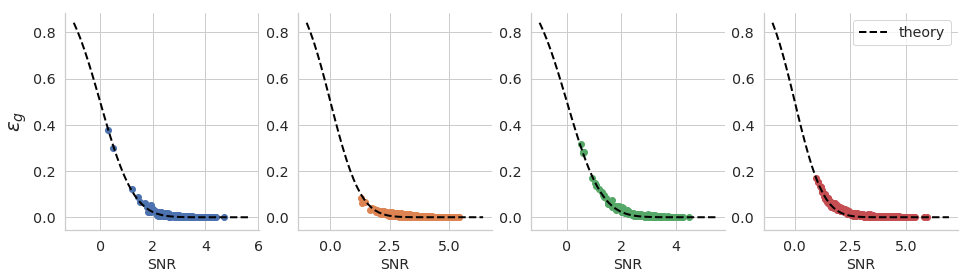

In [110]:
n_plots = 4
n_classes = 1000
with sns.axes_style('whitegrid'):    
    plt.figure(figsize=(16, n_plots//4*4))
    c = 0
    for i in range(n_plots):
        plt.subplot(n_plots//4,4,i+1)
        plt.scatter(SNR[i][np.arange(K)!=i],errs_5shot[i], c='C' + str(c%10))
        c+=1  # update color counter

        # Plot theory
        x = np.linspace(-1,np.nanmax(SNR[i])+1,50)
        plt.plot(x, H(x), c='black', linestyle='dashed', linewidth=2, label='theory')

        plt.xlabel('SNR', fontsize=14)
        if i%4==0:
            plt.ylabel(r'$\epsilon_g$', fontsize=20)
        if c==4:
            plt.legend()
        sns.despine()